# Model Notebook
Feature Engineering:
 - Datetime extraction
 - Introduce Phases
 - Use predicted average daily temperature to help fit model.

I have decided to implement 3 different models. The model that returns the best rmse gets to predict future.
1. SARIMAX
2. FBProphet
3. LightGBM

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holidays

# For SARIMAX
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For FBProphet
from fbprophet import Prophet

# For LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna

### Data Preprocessing
The original dataset can be found from data.ny.gov and time ranges from 2010-2020. <br>
https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga <br>
The counts are in hourly form and need to be resampled to Daily.
In addition, the bridges('plaza_id') are coded numerically and need to be renamed. <br>
Please note: I have combined Triboro Manhattan and Triboro Bronx into Triboro.

On 2017, NYC finished installing cashless tolls. I will, therefore, use data from 2018 and on because data was collected differently prior to 2017.

In [3]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    df = df.loc[df['Date_Hour'] >= '2018'].copy(deep=True)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df.drop(columns=['Plaza ID', 'Direction'], inplace=True)
    df.columns = ['datetime', 'ezpass', 'cash', 'plaza_id']
    _df = df.melt(id_vars=['datetime','plaza_id'], value_vars=['ezpass', 'cash'])
    _df['crossing'] = _df['plaza_id'] + '_' + _df['variable']
    
    _df.set_index('datetime', inplace=True)
    _df = _df.groupby(['crossing'])['value'].resample('1D').sum()
    _df = _df.unstack().T
    

    
    return _df


In [15]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    df = df.loc[df['Date_Hour'] >= '2018'].copy(deep=True)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df.drop(columns=['Plaza ID', 'Direction'], inplace=True)
    df.columns = ['datetime', 'ezpass', 'cash', 'plaza_id']
    _df = df.melt(id_vars=['datetime','plaza_id'], value_vars=['ezpass', 'cash'])
    _df.set_index('datetime', inplace=True)
    _df = _df.groupby(['plaza_id', 'variable'])['value'].resample('1D').sum()

    
#     _df.set_index('datetime', inplace=True)
#     _df = _df.groupby(['crossing'])['value'].resample('1D').sum()
#     _df = _df.unstack().T
    

    
    return _df

In [16]:
df = return_series('mta.csv')


In [17]:
df

plaza_id          variable  datetime  
Brooklyn Battery  cash      2018-01-01      3527
                            2018-01-02      4099
                            2018-01-03      4326
                            2018-01-04      1552
                            2018-01-05      3103
                                           ...  
Whitestone        ezpass    2020-10-06    101180
                            2020-10-07     99960
                            2020-10-08    104514
                            2020-10-09    119287
                            2020-10-10    111136
Name: value, Length: 18252, dtype: int64

In [19]:
df = df.unstack().T

In [20]:
df

plaza_id   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2018-01-01             3527  25636      1876  11829         5523  41017   
2018-01-02             4099  43061      2336  19539         5983  54627   
2018-01-03             4326  49679      2593  22014         6113  61870   
2018-01-04             1552  18932      1092   7211         1519  12983   
2018-01-05             3103  34904      1900  14939         4700  45150   
...                     ...    ...       ...    ...          ...    ...   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

plaza_id   Marine Parkway        Queens Midtown        Throgs Neck          \
variable             cash ezpass           cash ezpass        cash  ezpass   
datetime                                                                     
2018-01-01           1096  11022           7338  47569       16177   82169   
2018-01-02           1517  18370           6554  60446       12971   93293   
2018-01-03           1635  20432           7071  64654       13045  102907   
2018-01-04            571   5596           2687  23938        3518   24888   
2018-01-05           1102  12827           5465  49688        9585   70892   
...                   ...    ...            ...    ...         ...     ...   
2020-10-06           2518  18667          10831  52764       14178   83961   
2020-10-07           2476  17918          11425  56360       14752   86849   
2020-10-08           2559  18748          11800  58204       15760   90958   
2020-10-09           2531  17999          13433  61760       17321   95125   
2020-10-10           2605  16447          12107  48178       19018   91976   

plaza_id   Triboro         Verrazano        Whitestone          
variable      cash  ezpass      cash ezpass       cash  ezpass  
datetime                                                        
2018-01-01   22395  118380     11583  70340      18818   90468  
2018-01-02   20751  144179      9319  86330      14843  102368  
2018-01-03   21182  153968      9110  94396      15263  108711  
2018-01-04    7787   56350      3319  34501       4855   33259  
2018-01-05   16429  118824      6841  67534      11586   79643  
...            ...     ...       ...    ...        ...     ...  
2020-10-06   26219  130693     11193  86130      20675  101180  
2020-10-07   26443  134036     11166  86913      20208   99960  
2020-10-08   28160  140175     11907  88834      21469  104514  
2020-10-09   30816  142961     13464  93085      25545  119287  
2020-10-10   32227  132258     14218  85350      26894  111136  

[1014 rows x 18 columns]

### 9 Toll Bridges in NYC

There are some days when there were 0 crossings over bridges. (missing values). <br> For this project, I have decided to fill the missing values with the previous day count. <br>





In [21]:

_df = df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [22]:
_df

plaza_id   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2018-01-01             3527  25636      1876  11829         5523  41017   
2018-01-02             4099  43061      2336  19539         5983  54627   
2018-01-03             4326  49679      2593  22014         6113  61870   
2018-01-04             1552  18932      1092   7211         1519  12983   
2018-01-05             3103  34904      1900  14939         4700  45150   
...                     ...    ...       ...    ...          ...    ...   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

plaza_id   Marine Parkway        Queens Midtown        Throgs Neck          \
variable             cash ezpass           cash ezpass        cash  ezpass   
datetime                                                                     
2018-01-01           1096  11022           7338  47569       16177   82169   
2018-01-02           1517  18370           6554  60446       12971   93293   
2018-01-03           1635  20432           7071  64654       13045  102907   
2018-01-04            571   5596           2687  23938        3518   24888   
2018-01-05           1102  12827           5465  49688        9585   70892   
...                   ...    ...            ...    ...         ...     ...   
2020-10-06           2518  18667          10831  52764       14178   83961   
2020-10-07           2476  17918          11425  56360       14752   86849   
2020-10-08           2559  18748          11800  58204       15760   90958   
2020-10-09           2531  17999          13433  61760       17321   95125   
2020-10-10           2605  16447          12107  48178       19018   91976   

plaza_id   Triboro         Verrazano        Whitestone          
variable      cash  ezpass      cash ezpass       cash  ezpass  
datetime                                                        
2018-01-01   22395  118380     11583  70340      18818   90468  
2018-01-02   20751  144179      9319  86330      14843  102368  
2018-01-03   21182  153968      9110  94396      15263  108711  
2018-01-04    7787   56350      3319  34501       4855   33259  
2018-01-05   16429  118824      6841  67534      11586   79643  
...            ...     ...       ...    ...        ...     ...  
2020-10-06   26219  130693     11193  86130      20675  101180  
2020-10-07   26443  134036     11166  86913      20208   99960  
2020-10-08   28160  140175     11907  88834      21469  104514  
2020-10-09   30816  142961     13464  93085      25545  119287  
2020-10-10   32227  132258     14218  85350      26894  111136  

[1014 rows x 18 columns]

### Feature Engineering: Holidays
Holidays will be an important feature in determining daily toll traffic. I created a list of all the holidays from 2018-2021.

In [23]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020, 2021]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])
        
crossing_rates = {('Brooklyn Battery', 'cash'):9.50,
                 ('Brooklyn Battery', 'ezpass'):6.12,
                 ('Cross Bay', 'cash'):4.75,
                 ('Cross Bay', 'ezpass'):2.29,
                 ('Henry Hudson','cash'):7.00,
                 ('Henry Hudson','ezpass'):2.80,
                 ('Marine Parkway','cash'):4.75,
                 ('Marine Parkway','ezpass'):2.29,
                 ('Queens Midtown','cash'):9.50,
                 ('Queens Midtown','ezpass'):6.12,
                 ('Throgs Neck','cash'): 9.50,
                 ('Throgs Neck','ezpass'): 6.12,
                 ('Triboro','cash'): 9.50,
                 ('Triboro','ezpass'):6.12,
                 ('Verrazano','cash'):19.00,
                 ('Verrazano','ezpass'):12.24,
                 ('Whitestone','cash'):9.50,
                 ('Whitestone','ezpass'):6.12}

In [24]:
_df.columns

MultiIndex([('Brooklyn Battery',   'cash'),
            ('Brooklyn Battery', 'ezpass'),
            (       'Cross Bay',   'cash'),
            (       'Cross Bay', 'ezpass'),
            (    'Henry Hudson',   'cash'),
            (    'Henry Hudson', 'ezpass'),
            (  'Marine Parkway',   'cash'),
            (  'Marine Parkway', 'ezpass'),
            (  'Queens Midtown',   'cash'),
            (  'Queens Midtown', 'ezpass'),
            (     'Throgs Neck',   'cash'),
            (     'Throgs Neck', 'ezpass'),
            (         'Triboro',   'cash'),
            (         'Triboro', 'ezpass'),
            (       'Verrazano',   'cash'),
            (       'Verrazano', 'ezpass'),
            (      'Whitestone',   'cash'),
            (      'Whitestone', 'ezpass')],
           names=['plaza_id', 'variable'])

### Feature Engineering: Date Features
From datetime, I extract the month, day of the week, year, weekend... etc. <br> In addition, I have included the 8 events that occurred in **2020**
0. March 12 - Events with more than 500 people cancelled
1. March 22 - NYS Pause Program begins, all non-essential workers must stay home
2. April 16 - Governor Cuomo extendes the stay-at-home order and school closures to May 15
3. May 15 - Governor Cuomo extends PAUSE to May 28
4. June 8 - NYC begins Phase 1 opening
5. June 22 - NYC begins Phase 2 opening
6. July 7 - NYC begins Phase 3 opening
7. July 19 - NYC begins Phase 4 opening

The timeline was extracted from investopedia. <br>
https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986

In [25]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [26]:
_df = date_features(_df)
print(_df.shape)
_df.head()

(1014, 28)


plaza_id   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2018-01-01             3527  25636      1876  11829         5523  41017   
2018-01-02             4099  43061      2336  19539         5983  54627   
2018-01-03             4326  49679      2593  22014         6113  61870   
2018-01-04             1552  18932      1092   7211         1519  12983   
2018-01-05             3103  34904      1900  14939         4700  45150   

plaza_id   Marine Parkway        Queens Midtown         ... month dayofweek  \
variable             cash ezpass           cash ezpass  ...                   
datetime                                                ...                   
2018-01-01           1096  11022           7338  47569  ...     1         0   
2018-01-02           1517  18370           6554  60446  ...     1         1   
2018-01-03           1635  20432           7071  64654  ...     1         2   
2018-01-04            571   5596           2687  23938  ...     1         3   
2018-01-05           1102  12827           5465  49688  ...     1         4   

plaza_id    year week day quarter dayofyear Phase weekend holiday  
variable                                                           
datetime                                                           
2018-01-01  2018    1   1       1         1    -1       0       1  
2018-01-02  2018    1   2       1         2    -1       0       0  
2018-01-03  2018    1   3       1         3    -1       0       0  
2018-01-04  2018    1   4       1         4    -1       0       0  
2018-01-05  2018    1   5       1         5    -1       0       0  

[5 rows x 28 columns]

### Feature Engineer: Average Daily Temperatures
I will predict the average daily temperature from 2018 to current and use the y_hat values as a feature. The temperature data will train from 2010 to 2018.

The dataset comes from https://w2.weather.gov/climate/xmacis.php?wfo=okx with JFK, NY selected.
It ranges from 2010-2020. I will be only taking temp_average of each day.
The dataset will be made applicable via kaggle.


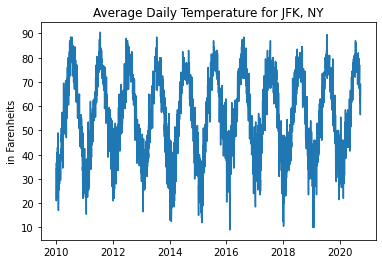

In [27]:
temperature = pd.read_csv('weather.csv', sep ='\t', engine ='python')
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
plt.plot(temperature['datetime'], temperature['temp_average'])
plt.title('Average Daily Temperature for JFK, NY');
plt.ylabel('in Farenheits');

I'll do a quick forecasting on average daily temperature using FBProphet. <br>
Training set was 2010-2017, Testing set: 2018-2020

In [28]:
_temperature = date_features(temperature.set_index('datetime')[['temp_average']])
_fb_weather = _temperature.reset_index()[['datetime', 'temp_average']]
_fb_weather.columns = ['ds', 'y']
_fb_weather.head()

,ds,y
0,2010-01-01,36.5
1,2010-01-02,25.0
2,2010-01-03,21.0
3,2010-01-04,26.0
4,2010-01-05,26.5


In [29]:
m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(_fb_weather)

In [30]:
future = m.make_future_dataframe(periods = 365*2)
forecast = m.predict(future)

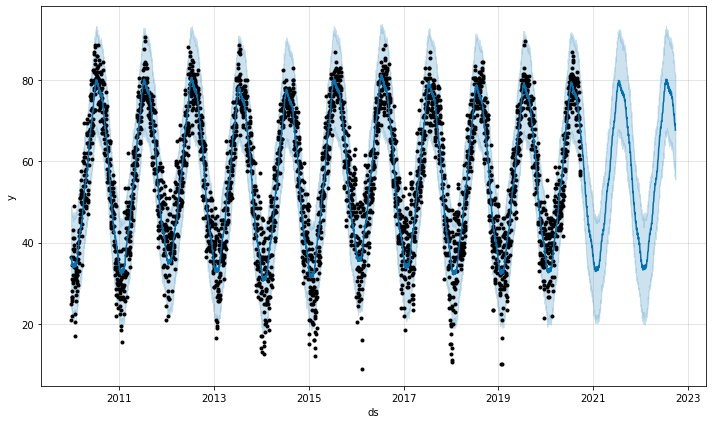

In [31]:
fig1 = m.plot(forecast)

In [32]:
sliced_forecast = forecast.loc[forecast['ds'].isin(pd.date_range(start='2018-01-01', end='2020-10-10'))]
sliced_forecast.reset_index(drop=True, inplace=True)

In [33]:
sliced_forecast = sliced_forecast[['ds', 'yhat']]
sliced_forecast.columns = ['datetime', 'temp_average']
sliced_forecast.set_index('datetime', inplace=True)
sliced_forecast.head()

,temp_average
datetime,
2018-01-01,34.744700
2018-01-02,35.134029
2018-01-03,34.775099
2018-01-04,34.159110
2018-01-05,33.598794


In [34]:
_df['temp_average'] = sliced_forecast['temp_average']

In [35]:
_df

plaza_id   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2018-01-01             3527  25636      1876  11829         5523  41017   
2018-01-02             4099  43061      2336  19539         5983  54627   
2018-01-03             4326  49679      2593  22014         6113  61870   
2018-01-04             1552  18932      1092   7211         1519  12983   
2018-01-05             3103  34904      1900  14939         4700  45150   
...                     ...    ...       ...    ...          ...    ...   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

plaza_id   Marine Parkway        Queens Midtown         ... dayofweek  year  \
variable             cash ezpass           cash ezpass  ...                   
datetime                                                ...                   
2018-01-01           1096  11022           7338  47569  ...         0  2018   
2018-01-02           1517  18370           6554  60446  ...         1  2018   
2018-01-03           1635  20432           7071  64654  ...         2  2018   
2018-01-04            571   5596           2687  23938  ...         3  2018   
2018-01-05           1102  12827           5465  49688  ...         4  2018   
...                   ...    ...            ...    ...  ...       ...   ...   
2020-10-06           2518  18667          10831  52764  ...         1  2020   
2020-10-07           2476  17918          11425  56360  ...         2  2020   
2020-10-08           2559  18748          11800  58204  ...         3  2020   
2020-10-09           2531  17999          13433  61760  ...         4  2020   
2020-10-10           2605  16447          12107  48178  ...         5  2020   

plaza_id   week day quarter dayofyear Phase weekend holiday temp_average  
variable                                                                  
datetime                                                                  
2018-01-01    1   1       1         1    -1       0       1    34.744700  
2018-01-02    1   2       1         2    -1       0       0    35.134029  
2018-01-03    1   3       1         3    -1       0       0    34.775099  
2018-01-04    1   4       1         4    -1       0       0    34.159110  
2018-01-05    1   5       1         5    -1       0       0    33.598794  
...         ...  ..     ...       ...   ...     ...     ...          ...  
2020-10-06   41   6       4       280     7       0       0    64.022413  
2020-10-07   41   7       4       281     7       0       0    63.618630  
2020-10-08   41   8       4       282     7       0       0    62.928621  
2020-10-09   41   9       4       283     7       0       0    62.261273  
2020-10-10   41  10       4       284     7       1       0    61.682719  

[1014 rows x 29 columns]

## Models

### Dummy Regressor
My baseline will be the average of the last 7 days for each bridge.
The sum of the 9 rmse (for each bridge) will be my metric.
I have chosen to use root mean squared error because it is more sensitive to larger errors than MAE(mean absolute error) or MAPE(mean absolute percentage error)

In [46]:
tr_start,tr_end = '2018-01-01','2020-09-05'
te_start,te_end = '2020-09-06','2020-10-10'
_total_dollars = 0
_total_dollar_values = []
for crossing,rate in crossing_rates.items():
    _total_dollars += _df[te_start:te_end][crossing].sum() * rate
    _total_dollar_values.append(_df[te_start:te_end][crossing].sum() * rate)

    
print('Total Revenue from 09-06-2020 to 10-10-2020: ',_total_dollars)

Total Revenue from 09-06-2020 to 10-10-2020:  173780402.32


In [50]:
_results_df = pd.DataFrame()
_results_df['bridges'] = list(crossing_rates.keys())
# _results_df['dummy_MA7'] = dummy_MA7
_results_df['Actual_Dollars'] = _total_dollar_values
_results_df

,bridges,Actual_Dollars
0,"(Brooklyn Battery, cash)",2281852.50
1,"(Brooklyn Battery, ezpass)",9145011.96
2,"(Cross Bay, cash)",553769.25
3,"(Cross Bay, ezpass)",1491600.66
4,"(Henry Hudson, cash)",2100210.00
5,"(Henry Hudson, ezpass)",5092189.20
6,"(Marine Parkway, cash)",464018.00
7,"(Marine Parkway, ezpass)",1495395.19
8,"(Queens Midtown, cash)",3810678.00
9,"(Queens Midtown, ezpass)",11176191.00


In [87]:
tr_start,tr_end = '2018-01-01','2020-09-05'
te_start,te_end = '2020-09-06','2020-10-10'


dummy_MA7 = []
_dummy_dollars = 0
for crossing,rate in crossing_rates.items():
    tes = _df[te_start:te_end][crossing]
    tra = _df[tr_start:tr_end][crossing]
    _dummy = pd.DataFrame()
    _dummy['datetime'] = pd.date_range(start='2020-09-06', end='2020-10-10')
    _dummy.set_index('datetime', inplace=True)
    _dummy[crossing] = tra.tail(7).mean()
    
    
    
    
    dummy_MA7.append(_dummy[crossing].sum() * rate)
    _dummy_dollars += _dummy[crossing].sum() * rate

print('Error on Dollars forecast(test) for Dummy: ', _dummy_dollars - _total_dollars)

Error on Dollars forecast(test) for Dummy:  5076338.430000007


In [90]:
_results_df['Dummy_Avg7'] = dummy_MA7
_results_df.sum(axis=0)

bridges           Brooklyn Battery
Actual_Dollars          1.7378e+08
Dummy_Avg7             1.78857e+08
dtype: object

### SARIMAX
I will use the features created from above as my independent exogenous variables. <br>
the values (p,d,q)x(P,D,Q,m), and trend was found through grid searching. <br>

I have used m=7 because the data points are daily.

### One Hot Encoder
After all features have been created, I will need to dummify the categorical features for SARIMAX.

In [122]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek', 'quarter', 'Phase']
_df_ohe = ohe.fit_transform(_df[categorical_columns]).toarray()
_df_ohe_df = pd.DataFrame(data = _df_ohe,
                           index = _df.index,
                          columns = ohe.get_feature_names(categorical_columns))

_df_merged = _df.merge(_df_ohe_df, left_index=True, right_index=True)
_df_ohe_df['weekend'] = _df['weekend']
_df_ohe_df['holiday'] = _df['holiday']
_df_ohe_df['temp_average'] = _df['temp_average']
_df_ohe_df.shape

C:\Users\albert\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning:

merging between different levels can give an unintended result (2 levels on the left,1 on the right)



(1014, 31)

In [123]:
_df_merged.columns

Index([  ('Brooklyn Battery', 'cash'), ('Brooklyn Battery', 'ezpass'),
                ('Cross Bay', 'cash'),        ('Cross Bay', 'ezpass'),
             ('Henry Hudson', 'cash'),     ('Henry Hudson', 'ezpass'),
           ('Marine Parkway', 'cash'),   ('Marine Parkway', 'ezpass'),
           ('Queens Midtown', 'cash'),   ('Queens Midtown', 'ezpass'),
              ('Throgs Neck', 'cash'),      ('Throgs Neck', 'ezpass'),
                  ('Triboro', 'cash'),          ('Triboro', 'ezpass'),
                ('Verrazano', 'cash'),        ('Verrazano', 'ezpass'),
               ('Whitestone', 'cash'),       ('Whitestone', 'ezpass'),
                        ('month', ''),              ('dayofweek', ''),
                         ('year', ''),                   ('week', ''),
                          ('day', ''),                ('quarter', ''),
                    ('dayofyear', ''),                  ('Phase', ''),
                      ('weekend', ''),                ('holiday', ''),
      

In [124]:
_df_merged.rename(columns = {('month', ''):'month', ('year', ''):'year', ('day', ''):'day', ('dayofyear', ''): 'dayofyear', 
                             ('weekend', ''):'weekend', ('temp_average', ''):'temp_average', ('dayofweek', ''):'dayofweek',
                            ('week', ''):'week', ('quarter', ''):'quarter', ('Phase', ''):'Phase', ('holiday', ''):'holiday'}, inplace=True)

In [95]:
def return_sarimax_dollars(bridge, rate, _order, _seasonal_order, _trend):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-09-05'
    te_start,te_end = '2020-09-06','2020-10-10'
    tra = _df_merged[tr_start:tr_end][bridge]
    tes = _df_merged[te_start:te_end][bridge]
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    
    model_SARIMAX = SARIMAX(tra, order=_order, seasonal_order= _seasonal_order, exog = exog_train, trend = _trend,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
    results = model_SARIMAX.fit(maxiter=1000)
    
    pred = results.predict(te_start,te_end, exog = exog_test)
    _dollars = pred.sum() * rate
    
    return _dollars

### Grid Search
I took this technique from machine learning mastery. It brute forces the combinations. <br>
I have set m = 7 because this is daily data. <br>
The selected params were (1,1,2)x(1,0,1,7) trend='n'


In [96]:
# code was taken from machine learning mastery
models = list()
p_params = [0, 1, 2]
d_params = [0, 1]
q_params = [0, 1, 2]
t_params = ['n','c','t','ct']
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]
m_params = [7]
# create config instances
for p in p_params:
    for d in d_params:
        for q in q_params:
            for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m), t]
                                models.append(cfg)


In [97]:
# # This grid search took around 40 hours. Please don't run this.
# _grid_sarimax = []
# for model in tqdm(models):
#     _each_grid = []
#     for i in bridges:
#         _each_grid.append(return_sarimax_rmse(i, model[0], model[1], model[2]))
#     print((sum(l7), model))
#     _grid_sarimax.append((sum(l7), model))

In [99]:
# Please note, I fit a sarimax model for each of the 9 bridges and returned an rmse from the test set.
# I should have 9 rmse (one for each bridge), the summation of the rmse will be the final metric.


    
_sarimax_dollar_values = []
_sarimax_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _bridge_dollar = return_sarimax_dollars(crossing, rate, (1,1,2), (1,0,1,7), 'n')
    _sarimax_dollars += _bridge_dollar
    _sarimax_dollar_values.append(_bridge_dollar)

100%|██████████| 18/18 [03:00<00:00, 10.05s/it]


In [101]:
print('Error on Dollars forecast(test) for SARMIAX: ',_sarimax_dollars - _total_dollars)

Error on Dollars forecast(test) for SARMIAX:  -660873.628728658


In [102]:
_results_df['SARIMAX'] = _sarimax_dollar_values
_results_df

,bridges,Actual_Dollars,Dummy_Avg7,SARIMAX
0,"(Brooklyn Battery, cash)",2281852.50,2371105.00,2.291756e+06
1,"(Brooklyn Battery, ezpass)",9145011.96,9281622.60,9.212363e+06
2,"(Cross Bay, cash)",553769.25,665617.50,6.209580e+05
3,"(Cross Bay, ezpass)",1491600.66,1675386.90,1.586853e+06
4,"(Henry Hudson, cash)",2100210.00,2172765.00,2.111212e+06
5,"(Henry Hudson, ezpass)",5092189.20,5042996.00,4.889591e+06
6,"(Marine Parkway, cash)",464018.00,635265.00,5.993505e+05
7,"(Marine Parkway, ezpass)",1495395.19,1797524.05,1.678732e+06
8,"(Queens Midtown, cash)",3810678.00,3901032.50,3.696822e+06
9,"(Queens Midtown, ezpass)",11176191.00,11050547.40,1.074555e+07


In [103]:
_results_df.sum(axis=0)

bridges           Brooklyn Battery
Actual_Dollars          1.7378e+08
Dummy_Avg7             1.78857e+08
SARIMAX                 1.7312e+08
dtype: object

### FBProphet
After implement SARIMAX, I will now move on to FBProphet. <br>
Please note, the FBProphet was not hyperturned

In [109]:
_df_merged.columns

Index([  ('Brooklyn Battery', 'cash'), ('Brooklyn Battery', 'ezpass'),
                ('Cross Bay', 'cash'),        ('Cross Bay', 'ezpass'),
             ('Henry Hudson', 'cash'),     ('Henry Hudson', 'ezpass'),
           ('Marine Parkway', 'cash'),   ('Marine Parkway', 'ezpass'),
           ('Queens Midtown', 'cash'),   ('Queens Midtown', 'ezpass'),
              ('Throgs Neck', 'cash'),      ('Throgs Neck', 'ezpass'),
                  ('Triboro', 'cash'),          ('Triboro', 'ezpass'),
                ('Verrazano', 'cash'),        ('Verrazano', 'ezpass'),
               ('Whitestone', 'cash'),       ('Whitestone', 'ezpass'),
                        ('month', ''),              ('dayofweek', ''),
                         ('year', ''),                   ('week', ''),
                          ('day', ''),                ('quarter', ''),
                    ('dayofyear', ''),                  ('Phase', ''),
                      ('weekend', ''),                ('holiday', ''),
      

In [133]:
def return_prophet_dollars(bridge, rate):
    tr_start,tr_end = '2018-01-01','2020-09-05'

    tra = _df_merged[tr_start:tr_end][[bridge]]

    _fb_exog = _df_merged[['month', 'dayofweek', 'quarter',
           'Phase', 'weekend', 'holiday', 'temp_average']]

    tra = tra.join(_fb_exog)



    exog_train = _df_ohe_df[tr_start:tr_end]

    tra = tra.reset_index()
    tra = tra.rename(columns = {bridge:'y', 'datetime': 'ds'})



    m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
    for i in _fb_exog.columns:
        m.add_regressor(i)


    m.fit(tra)
    
    # Please change the periods after changing the te_start and te_end. For this case i have made periods 35 because there are 35 days on the the test set.
    future = m.make_future_dataframe(periods=35)
    future.set_index('ds', inplace=True)
    future = future.join(_fb_exog)
    future.reset_index(inplace=True)
    pred = m.predict(future[-35:])
    _dollars = pred['yhat'].sum() * rate
    
    return _dollars

In [134]:
_fbprophet_dollar_values = []

_fbprophet_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _dollar_value = return_prophet_dollars(crossing, rate)
    _fbprophet_dollars += _dollar_value
    _fbprophet_dollar_values.append(_dollar_value)


100%|██████████| 18/18 [09:59<00:00, 33.30s/it]


In [135]:
print('Error on Dollars forecast(test) for FBProphet: ',_fbprophet_dollars - _total_dollars)

Error on Dollars forecast(test) for FBProphet:  -413098.18853238225


In [136]:
_results_df['FBProphet'] = _fbprophet_dollar_values

In [137]:
_results_df

,bridges,Actual_Dollars,Dummy_Avg7,SARIMAX,FBProphet
0,"(Brooklyn Battery, cash)",2281852.50,2371105.00,2.291756e+06,2.239862e+06
1,"(Brooklyn Battery, ezpass)",9145011.96,9281622.60,9.212363e+06,9.290837e+06
2,"(Cross Bay, cash)",553769.25,665617.50,6.209580e+05,5.210029e+05
3,"(Cross Bay, ezpass)",1491600.66,1675386.90,1.586853e+06,1.444499e+06
4,"(Henry Hudson, cash)",2100210.00,2172765.00,2.111212e+06,1.980509e+06
5,"(Henry Hudson, ezpass)",5092189.20,5042996.00,4.889591e+06,5.192612e+06
6,"(Marine Parkway, cash)",464018.00,635265.00,5.993505e+05,5.032232e+05
7,"(Marine Parkway, ezpass)",1495395.19,1797524.05,1.678732e+06,1.360216e+06
8,"(Queens Midtown, cash)",3810678.00,3901032.50,3.696822e+06,3.455259e+06
9,"(Queens Midtown, ezpass)",11176191.00,11050547.40,1.074555e+07,1.016044e+07


In [138]:
_results_df.sum(axis=0)

bridges           Brooklyn Battery
Actual_Dollars          1.7378e+08
Dummy_Avg7             1.78857e+08
SARIMAX                 1.7312e+08
FBProphet              1.73367e+08
dtype: object

### LightGBM
After using tuned SARIMAX and a more-or-less generic FBProphet, I thought it was a good opportunity to try changing the time series problem into a decision tree regression problem. Instead of having 9 separate models for each bridge, we can have 1 GBDT model. This is done by first melting all the columns and making the dataframe long. As I have created features in the SARIMAX and FBProphet models, I will do the same here.

In [139]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    df = df.loc[df['Date_Hour'] >= '2018'].copy(deep=True)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df.drop(columns=['Plaza ID', 'Direction'], inplace=True)
    df.columns = ['datetime', 'ezpass', 'cash', 'plaza_id']
    _df = df.melt(id_vars=['datetime','plaza_id'], value_vars=['ezpass', 'cash'])
#     _df['crossing'] = _df['plaza_id'] + '_' + _df['variable']
    
#     _df.set_index('datetime', inplace=True)
#     _df = _df.groupby(['crossing'])['value'].resample('1D').sum()
#     _df = _df.unstack().T
    

    
    return _df


In [140]:
lgbm_df = return_series('mta.csv')

In [141]:
lgbm_df.set_index('datetime', inplace=True)

In [142]:
_ffill_lgbm = lgbm_df.groupby(['plaza_id', 'variable'])['value'].resample('1D').sum()

In [143]:
_ffill_lgbm = _ffill_lgbm.reset_index()

In [144]:
_ffill_lgbm = _ffill_lgbm.pivot(index='datetime', columns = ['plaza_id', 'variable'], values='value')

In [145]:
for i in crossing_rates.keys():
    _ffill_lgbm[i] = _ffill_lgbm[i].replace(to_replace=0, method='ffill')

In [146]:
_ffill_lgbm = _ffill_lgbm.unstack().reset_index()

In [147]:
_ffill_lgbm.rename(columns={0: 'value'}, inplace=True)

In [148]:
_ffill_lgbm.set_index('datetime', inplace=True)

In [149]:
_var = {'cash':0, 'ezpass': 1}
_ffill_lgbm['variable'] = [_var[item] for item in _ffill_lgbm['variable']]

In [150]:
_ffill_lgbm.isna().sum()

plaza_id    0
variable    0
value       0
dtype: int64

In [151]:
le = LabelEncoder()
_ffill_lgbm['plaza_id'] = le.fit_transform(_ffill_lgbm['plaza_id'])

In [152]:
_ffill_lgbm

,plaza_id,variable,value
datetime,,,
2018-01-01,0,0,3527
2018-01-02,0,0,4099
2018-01-03,0,0,4326
2018-01-04,0,0,1552
2018-01-05,0,0,3103
...,...,...,...
2020-10-06,8,1,101180
2020-10-07,8,1,99960
2020-10-08,8,1,104514


In [153]:
_ffill_lgbm = date_features(_ffill_lgbm)

_ffill_lgbm = _ffill_lgbm.join(sliced_forecast)
# There are many instances where I'll set an index to datetime and reset it.
# This is my fault for not making the data preprocessing functions take the same columns. For example: date_features takes index, while date_lag takes the column
_ffill_lgbm.reset_index(inplace=True)

In [154]:
_ffill_lgbm.rename(columns={'plaza_id':'crossing'}, inplace=True)

In [155]:
# Creating 3 sliced dataframes
train_set = _ffill_lgbm.loc[_ffill_lgbm['datetime'] <= '2020-09-05'].copy(deep=True)
test_set = _ffill_lgbm.loc[(_ffill_lgbm['datetime'] > '2020-09-05') & (_ffill_lgbm['datetime'] <= '2020-10-10')].copy(deep=True)
pred_set = _ffill_lgbm.loc[(_ffill_lgbm['datetime'] > '2020-09-05')].copy(deep=True)
pred_set['value'] = np.nan
pred_set.tail()

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
18247,2020-10-10,6,1,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18248,2020-10-10,7,0,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18249,2020-10-10,7,1,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18250,2020-10-10,8,0,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18251,2020-10-10,8,1,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719


In [156]:
train_set

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
0,2018-01-01,0,0,3527,1,0,2018,1,1,1,1,-1,0,1,34.744700
1,2018-01-01,0,1,25636,1,0,2018,1,1,1,1,-1,0,1,34.744700
2,2018-01-01,1,0,1876,1,0,2018,1,1,1,1,-1,0,1,34.744700
3,2018-01-01,1,1,11829,1,0,2018,1,1,1,1,-1,0,1,34.744700
4,2018-01-01,2,0,5523,1,0,2018,1,1,1,1,-1,0,1,34.744700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17617,2020-09-05,6,1,121053,9,5,2020,36,5,3,249,7,1,0,72.496286
17618,2020-09-05,7,0,14508,9,5,2020,36,5,3,249,7,1,0,72.496286
17619,2020-09-05,7,1,82759,9,5,2020,36,5,3,249,7,1,0,72.496286
17620,2020-09-05,8,0,26880,9,5,2020,36,5,3,249,7,1,0,72.496286


In [158]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    
#     _df['lag_1'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(1)
#     _df['lag_2'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(2)
    
#     _df['mean_lag1_roll7'] = _df[['crossing', 'variable','value', 'lag_1']].groupby(['crossing', 'variable'])['lag_1'].apply(lambda x: x.rolling(7).mean())
#     _df['mean_lag1_roll3'] = _df[['crossing', 'variable','value', 'lag_1']].groupby(['crossing', 'variable'])['lag_1'].apply(lambda x: x.rolling(3).mean())
#     _df['diff_7'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].diff(7)
    
    _df['lag_7'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(7)
    _df['lag_14'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(14)
    _df['lag_21'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(21)
    _df['lag_28'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(28)
#     _df['lag_35'] = _df[['crossing', 'value']].groupby('crossing')['value'].shift(35)

    
    
    _df['mean_lag7_roll7'] = _df[['crossing', 'variable','value', 'lag_7']].groupby(['crossing', 'variable'])['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['crossing', 'variable','value', 'lag_7']].groupby(['crossing', 'variable'])['lag_7'].apply(lambda x: x.rolling(28).mean())
    _df['mean_lag28_roll7'] = _df[['crossing', 'variable','value', 'lag_28']].groupby(['crossing', 'variable'])['lag_28'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag28_roll28'] = _df[['crossing', 'variable','value', 'lag_28']].groupby(['crossing', 'variable'])['lag_28'].apply(lambda x: x.rolling(28).mean())
    _df['week'] = _df['week'].astype('int64')
    
    return _df

In [159]:
train_set = date_lags(train_set)
train_set.tail()

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,...,holiday,temp_average,lag_7,lag_14,lag_21,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
17617,2020-09-05,6,1,121053,9,5,2020,36,5,3,...,0,72.496286,100790.0,121095.0,120261.0,113866.0,126619.571429,126622.571429,122801.571429,124957.857143
17618,2020-09-05,7,0,14508,9,5,2020,36,5,3,...,0,72.496286,12372.0,14433.0,14877.0,14061.0,12774.142857,12780.142857,12172.571429,12332.964286
17619,2020-09-05,7,1,82759,9,5,2020,36,5,3,...,0,72.496286,72128.0,82315.0,82922.0,79371.0,84448.285714,83557.714286,79144.571429,80685.571429
17620,2020-09-05,8,0,26880,9,5,2020,36,5,3,...,0,72.496286,21921.0,26148.0,26577.0,25060.0,22861.142857,22830.035714,21770.571429,21843.785714
17621,2020-09-05,8,1,105655,9,5,2020,36,5,3,...,0,72.496286,85478.0,102757.0,105698.0,98837.0,102611.000000,101443.571429,95833.285714,96282.857143


In [172]:
categorical_features = ['crossing', 'variable', 'month', 'dayofweek', 'day', 'week', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value', 'year']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [178]:
X_valid = train_set.loc[train_set['datetime'] >= '2020-08-01'][train_cols]
y_valid = train_set.loc[train_set['datetime'] >= '2020-08-01']['value']
X_train = train_set.loc[train_set['datetime'] < '2020-08-01'][train_cols]
y_train = train_set.loc[train_set['datetime'] < '2020-08-01']['value']

In [179]:
# train test split
# X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [180]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False) 


#### Optuna
Optuna looks very similiarly to randomized Search CV. More importantly, it displays a progress bar and results paramter after each iteration. <br> I decided to use this to find the best parameters.

In [213]:

def objective(trial):
    params = {
        'objective': 'poisson',
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 18, 64),
        'num_leaves': trial.suggest_int('num_leaves', 54, 124),
        'metric' :'rmse',

        'learning_rate' : 0.05,


        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        'lambda_l1' : trial.suggest_loguniform('l1', 0.1, 0.9),
        'lambda_l2' : trial.suggest_loguniform('l2', 0.1, 0.9),

        'verbosity': 1}


    m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=500, early_stopping_rounds=500)
    
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['value'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')
    
    
    _inverse_variable = {0: 'cash', 1: 'ezpass'}
    _lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-06', '2020-10-10'))][['datetime', 'crossing', 'variable',  'value']]
    _lgbm_pred['variable'] = [_inverse_variable[item] for item in _lgbm_pred['variable']]
    _lgbm_pred['crossing'] = le.inverse_transform(_lgbm_pred['crossing'])
    
    _lgbm_pivot = _lgbm_pred.pivot(index='datetime', columns=['crossing', 'variable'], values='value')
#     test_set['variable'] = [_inverse_variable[item] for item in test_set['variable']]
#     test_set['crossing'] = le.inverse_transform(test_set['crossing'])
    
#     _test_pivot = test_set.pivot(index='datetime', columns = ['crossing', 'variable'], values='value')
    
    _lgbm_dollars = 0
    _lgbm_rmse = []
    for i,x in crossing_rates.items():
        _lgbm_dollars += _lgbm_pivot[i].sum() * x
        _lgbm_rmse.append(np.sqrt(mean_squared_error(_test_pivot[i], _lgbm_pivot[i])))
    
    
    return sum(_lgbm_rmse)

In [214]:
# 100 trials: this can take a while, feel free to interrupt at any time
study = optuna.create_study()
study.optimize(objective, n_trials=100)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4315.32
[1000]	valid_0's rmse: 4303.84
[1500]	valid_0's rmse: 4305.83
Early stopping, best iteration is:
[1187]	valid_0's rmse: 4294.6


  7%|▋         | 35/499 [00:04<00:59,  7.79it/s]


end of loop


[I 2020-10-14 08:12:33,551] Finished trial#0 with value: 47858.73008045717 with parameters: {'max_depth': 18, 'num_leaves': 54, 'bag_frac': 0.542752424549765, 'feat_frac': 0.7053654596616145, 'l1': 0.6922348283230859, 'l2': 0.20718339824467727}. Best is trial#0 with value: 47858.73008045717.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4189.83
[1000]	valid_0's rmse: 4191.85
Early stopping, best iteration is:
[804]	valid_0's rmse: 4174.96


  7%|▋         | 35/499 [00:03<00:52,  8.84it/s]


end of loop


[I 2020-10-14 08:15:15,781] Finished trial#1 with value: 45833.75962736491 with parameters: {'max_depth': 20, 'num_leaves': 85, 'bag_frac': 0.6387481315502649, 'feat_frac': 0.6127746039690583, 'l1': 0.7314687092879231, 'l2': 0.1385228625995531}. Best is trial#1 with value: 45833.75962736491.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4356.57
[1000]	valid_0's rmse: 4333


KeyboardInterrupt: 

In [183]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 33,
    'num_leaves': 105,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.5322891910761054,
    'feature_fraction': 0.6669831078168111,
    'lambda_l1' : 0.3835478797094356,
    'lambda_l2' : 0.13698763208906273,
    'verbosity': 1

}
# params taken from optuna
# {'max_depth': 38, 'num_leaves': 83, 'bag_frac': 0.5163386620025411, 'feat_frac': 0.8282029364551513, 'l1': 0.32608335857159515, 'l2': 0.47993551029860304}
#{'max_depth': 33, 'num_leaves': 105, 'bag_frac': 0.5322891910761054, 'feat_frac': 0.6669831078168111, 'l1': 0.3835478797094356, 'l2': 0.13698763208906273}

In [184]:
m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 5504.32
[200]	valid_0's rmse: 4363.26
[300]	valid_0's rmse: 4316.82
[400]	valid_0's rmse: 4317.26
[500]	valid_0's rmse: 4311.7
[600]	valid_0's rmse: 4323.2
[700]	valid_0's rmse: 4317.94
Early stopping, best iteration is:
[292]	valid_0's rmse: 4306.18


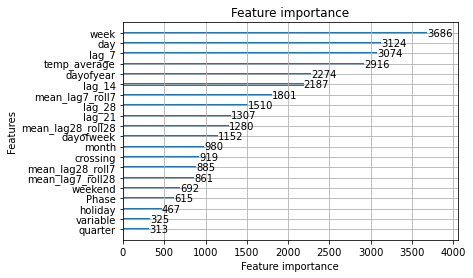

In [185]:
lgb.plot_importance(m_lgb)

In [186]:
train_roll = train_set.copy(deep=True)
try:
    for i in tqdm(range(1,500)):
        _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat.reset_index(inplace=True, drop=True)
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['value'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

  7%|▋         | 35/499 [00:05<01:09,  6.68it/s]


end of loop


In [187]:
train_roll

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,...,holiday,temp_average,lag_7,lag_14,lag_21,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,0,0,3527.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,0,1,25636.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,1,0,1876.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,1,1,11829.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,2,0,5523.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18247,2020-10-10,6,1,119609.473280,10,5,2020,41,10,4,...,0,61.682719,117849.847577,119345.687606,115286.317100,114371.203305,129713.665480,129719.414659,128700.422072,128806.819804
18248,2020-10-10,7,0,14242.905925,10,5,2020,41,10,4,...,0,61.682719,14547.691196,13601.202418,13749.598872,13917.843005,12849.372306,12441.211455,12409.791981,12891.947995
18249,2020-10-10,7,1,87811.455660,10,5,2020,41,10,4,...,0,61.682719,86346.625401,87686.177906,86192.904655,84556.231855,86434.634544,86221.243098,85268.173867,85483.186324
18250,2020-10-10,8,0,23550.462872,10,5,2020,41,10,4,...,0,61.682719,24473.548865,24055.329021,23944.604947,24267.793249,21848.053297,21532.030144,21495.830673,22809.636240


In [188]:
_lgbm_pred

NameError: name '_lgbm_pred' is not defined

In [189]:
_inverse_variable = {0: 'cash', 1: 'ezpass'}
_lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-06', '2020-10-10'))][['datetime', 'crossing', 'variable',  'value']]
_lgbm_pred['variable'] = [_inverse_variable[item] for item in _lgbm_pred['variable']]
_lgbm_pred['crossing'] = le.inverse_transform(_lgbm_pred['crossing'])

In [190]:
_lgbm_pred

,datetime,crossing,variable,value
17622,2020-09-06,Brooklyn Battery,cash,5750.569497
17623,2020-09-06,Brooklyn Battery,ezpass,35164.255611
17624,2020-09-06,Cross Bay,cash,4047.107247
17625,2020-09-06,Cross Bay,ezpass,19059.359494
17626,2020-09-06,Henry Hudson,cash,8144.033480
...,...,...,...,...
18247,2020-10-10,Triboro,ezpass,119609.473280
18248,2020-10-10,Verrazano,cash,14242.905925
18249,2020-10-10,Verrazano,ezpass,87811.455660
18250,2020-10-10,Whitestone,cash,23550.462872


In [191]:
_lgbm_pivot = _lgbm_pred.pivot(index='datetime', columns=['crossing', 'variable'], values='value')

In [192]:
_lgbm_pivot.columns

MultiIndex([('Brooklyn Battery',   'cash'),
            ('Brooklyn Battery', 'ezpass'),
            (       'Cross Bay',   'cash'),
            (       'Cross Bay', 'ezpass'),
            (    'Henry Hudson',   'cash'),
            (    'Henry Hudson', 'ezpass'),
            (  'Marine Parkway',   'cash'),
            (  'Marine Parkway', 'ezpass'),
            (  'Queens Midtown',   'cash'),
            (  'Queens Midtown', 'ezpass'),
            (     'Throgs Neck',   'cash'),
            (     'Throgs Neck', 'ezpass'),
            (         'Triboro',   'cash'),
            (         'Triboro', 'ezpass'),
            (       'Verrazano',   'cash'),
            (       'Verrazano', 'ezpass'),
            (      'Whitestone',   'cash'),
            (      'Whitestone', 'ezpass')],
           names=['crossing', 'variable'])

In [193]:
crossing_rates = {('Brooklyn Battery', 'cash'):9.50,
                 ('Brooklyn Battery', 'ezpass'):6.12,
                 ('Cross Bay', 'cash'):4.75,
                 ('Cross Bay', 'ezpass'):2.29,
                 ('Henry Hudson','cash'):7.00,
                 ('Henry Hudson','ezpass'):2.80,
                 ('Marine Parkway','cash'):4.75,
                 ('Marine Parkway','ezpass'):2.29,
                 ('Queens Midtown','cash'):9.50,
                 ('Queens Midtown','ezpass'):6.12,
                 ('Throgs Neck','cash'): 9.50,
                 ('Throgs Neck','ezpass'): 6.12,
                 ('Triboro','cash'): 9.50,
                 ('Triboro','ezpass'):6.12,
                 ('Verrazano','cash'):19.00,
                 ('Verrazano','ezpass'):12.24,
                 ('Whitestone','cash'):9.50,
                 ('Whitestone','ezpass'):6.12}

In [194]:
crossing_rates

{('Brooklyn Battery', 'cash'): 9.5,
 ('Brooklyn Battery', 'ezpass'): 6.12,
 ('Cross Bay', 'cash'): 4.75,
 ('Cross Bay', 'ezpass'): 2.29,
 ('Henry Hudson', 'cash'): 7.0,
 ('Henry Hudson', 'ezpass'): 2.8,
 ('Marine Parkway', 'cash'): 4.75,
 ('Marine Parkway', 'ezpass'): 2.29,
 ('Queens Midtown', 'cash'): 9.5,
 ('Queens Midtown', 'ezpass'): 6.12,
 ('Throgs Neck', 'cash'): 9.5,
 ('Throgs Neck', 'ezpass'): 6.12,
 ('Triboro', 'cash'): 9.5,
 ('Triboro', 'ezpass'): 6.12,
 ('Verrazano', 'cash'): 19.0,
 ('Verrazano', 'ezpass'): 12.24,
 ('Whitestone', 'cash'): 9.5,
 ('Whitestone', 'ezpass'): 6.12}

In [195]:
test_set['variable'] = [_inverse_variable[item] for item in test_set['variable']]

In [196]:
test_set['crossing'] = le.inverse_transform(test_set['crossing'])

In [197]:
_test_pivot = test_set.pivot(index='datetime', columns = ['crossing', 'variable'], values='value')

In [198]:
_test_dollars = 0
for i,x in crossing_rates.items():
    _test_dollars += _test_pivot[i].sum() * x

In [199]:
_test_dollars

173780402.32

In [200]:
_lgbm_dollars = 0
for i,x in crossing_rates.items():
    _lgbm_dollars += _lgbm_pivot[i].sum() * x

In [201]:
_lgbm_dollars

173793321.02383623

In [202]:
_lgbm_dollars - _test_dollars

12918.703836232424

In [203]:
_test_pivot

crossing   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2020-09-06             6117  30212      5033  21712         7646  39753   
2020-09-07             5096  26185      4479  19265         7338  39943   
2020-09-08             7067  48038      3723  20921         8249  52342   
2020-09-09             7299  49254      3197  19495         7970  54056   
2020-09-10             7001  48671      2972  17770         7947  52680   
2020-09-11             8412  48466      3594  20899         9942  60717   
2020-09-12             6373  33000      3547  18167         9498  49125   
2020-09-13             5622  29947      2974  15320         6984  40328   
2020-09-14             7039  47134      3448  19321         7758  50456   
2020-09-15             7059  48456      3312  19223         8001  54097   
2020-09-16             7144  47924      3201  19159         7893  53611   
2020-09-17             7414  50449      3367  19263         8446  56802   
2020-09-18             7892  48118      3389  19678        10121  60502   
2020-09-19             6688  33910      3244  17017         9485  48963   
2020-09-20             5145  26614      2776  14633         7892  42830   
2020-09-21             6883  45178      2966  18109         8070  50502   
2020-09-22             7137  48129      3328  19380         8084  52792   
2020-09-23             7354  50102      3612  20659         8520  56115   
2020-09-24             7553  49494      3173  19502         9238  58189   
2020-09-25             8190  50476      3599  20703        10649  61564   
2020-09-26             6756  36662      3269  17050         9897  51542   
2020-09-27             5292  28346      2937  15961         8291  43456   
2020-09-28             5762  35586      3005  17535         7211  45275   
2020-09-29             6881  48250      3013  18058         7680  51968   
2020-09-30             7298  49791      3262  18869         8275  54657   
2020-10-01             7871  51671      3405  20417         8800  58247   
2020-10-02             7681  48991      3482  20210        10208  60587   
2020-10-03             7157  35244      3133  16884         9799  50638   
2020-10-04             4910  26317      2573  14302         8245  44802   
2020-10-05             6750  45939      3066  18206         7562  48787   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

crossing   Marine Parkway        Queens Midtown        Throgs Neck         \
variable             cash ezpass           cash ezpass        cash ezpass   
datetime                                                                    
2020-09-06           5524  26312           9804  34976       21163  95740   
2020-09-07           4510  23131           9018  35091       19276  88550   
2020-09-08           3450  22074          11666  54996       16068  90434   
2020-09-09           2877  19944          11353  55885       15121  89586   
2020-09-10           2565  17930          11189  54720       14689  85469   
2020-09-11           3217  21266          13150  60236       17254  93955   
2020-09-12           3249  18416          11830  46223       19070  91079   
2020-09-13           2883  15867           9668  38228       17919  85451   
2020-09-14           3048  19650          11071  52747       14968  85243   
2020-09-15           2978  19763          11623  56283       14776  86100   
2020-09-16           2699  19577          11182  55362       14509  86537   
2020-09-17           2637  20264          12130  59576       15200  900

In [204]:
_lgbm_pivot

crossing   Brooklyn Battery                  Cross Bay                \
variable               cash        ezpass         cash        ezpass   
datetime                                                               
2020-09-06      5750.569497  35164.255611  4047.107247  19059.359494   
2020-09-07      6704.880767  36560.768285  3413.537745  17500.124520   
2020-09-08      6687.806107  48452.367107  3383.893626  19719.190633   
2020-09-09      6792.212464  48752.615271  3281.727385  18599.480052   
2020-09-10      7408.163513  51773.564889  3133.079169  19553.207546   
2020-09-11      7665.390808  49230.046914  4395.740424  22037.858303   
2020-09-12      6408.066514  33300.864604  3658.579674  18739.629985   
2020-09-13      5838.011342  36424.179852  3922.725901  18149.253241   
2020-09-14      6874.488892  46812.469248  3740.624960  18921.595140   
2020-09-15      6885.242288  49851.332227  3801.582444  20339.647385   
2020-09-16      6866.139543  50434.082760  3759.581632  18753.038941   
2020-09-17      7432.658525  52160.573530  3500.187411  20352.921250   
2020-09-18      7789.746211  50938.095029  4193.187160  21712.585879   
2020-09-19      6748.226517  36678.451639  3622.453140  19626.264291   
2020-09-20      5878.159903  38007.768658  3537.507281  18152.631914   
2020-09-21      6846.902462  44465.956552  3445.801760  18464.049730   
2020-09-22      6862.051334  48559.284876  3520.118728  20088.362884   
2020-09-23      6812.356844  48224.378989  3429.115062  19287.755123   
2020-09-24      7412.333413  50325.208489  3479.469319  19666.164511   
2020-09-25      7805.268132  49735.993631  3997.290370  21366.562839   
2020-09-26      6705.869640  39464.950473  3611.385319  19060.266848   
2020-09-27      6309.965380  39341.981039  3622.662786  18436.450360   
2020-09-28      7206.394586  44247.086455  3587.600372  18970.951414   
2020-09-29      7177.126064  47377.264793  3705.518210  19200.686014   
2020-09-30      7189.112154  46366.630831  3418.560540  19025.267375   
2020-10-01      7907.306986  48358.353626  3372.217302  19770.102037   
2020-10-02      8227.977411  48181.856859  3853.468786  20628.475587   
2020-10-03      7419.599658  38726.421828  3456.651293  19491.671759   
2020-10-04      6839.264448  37545.643472  3411.906976  18786.079037   
2020-10-05      7017.138746  47188.977307  3224.248653  18122.273281   
2020-10-06      6946.471281  50144.852098  3188.686131  19007.274406   
2020-10-07      7065.806549  48362.693310  3148.717441  18451.587046   
2020-10-08      7494.698324  51791.341977  3171.256319  19590.012591   
2020-10-09      7781.790311  50437.090707  3507.654355  20113.380212   
2020-10-10      7393.970089  42038.080035  3205.901944  18961.376430   

crossing    Henry Hudson               Marine Parkway                \
variable            cash        ezpass           cash        ezpass   
datetime                                                              
2020-09-06   8144.033480  45849.345552    4427.865395  21373.288730   
2020-09-07   7476.841179  41025.853688    2733.265395  18199.549590   
2020-09-08   7728.838823  53367.859593    2838.026439  20334.919122   
2020-09-09   7751.641735  54210.630805    2907.897857  18990.757753   
2020-09-10   8702.097228  58385.659258    2890.311872  19973.363120   
2020-09-11   9874.479582  61355.067305    3813.043925  23086.779435   
2020-09-12   8952.537347  46040.814660    3439.765801  18485.799797   
2020-09-13   7901.449781  45306.203062    3771.267968  19554.763313   
2020-09-14   7689.877981  50425.922917    3110.984079  19613.235245   
2020-09-15   7826.343235  54886.984818    3281.248896  20946.806046   
2020-09-16   7847.417047  55748.322019    3083.984051  19012.975712   
2020-09-17   8714.786939  58828.513112    3225.052162  21117.861728   
2020-09-18   9914.833161  61400.426229    3623.542367  23603.577465   
2020-09-19   9438.769951  45497.047675    3485.401942  19724.036709   
2020-09-20   7956.383365  42654.744465    3490.022935  2

In [209]:
_lgbm_rmse = []
_lgbm_summation = 0
for i in crossing_rates.keys():
    _lgbm_rmse.append(np.sqrt(mean_squared_error(_test_pivot[i], _lgbm_pivot[i])))

In [212]:
sum(_lgbm_rmse)

47293.25055768396

In [216]:
_lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-06', '2020-10-10'))][['datetime', 'crossing', 'variable',  'value']]
# _lgbm_pred
_lgbm_pred['crossing'] = le.inverse_transform(_lgbm_pred['crossing'])
_lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='crossing', values='value')
test_set_pivot = test_set.pivot(index='datetime', columns = 'crossing', values='value')
test_set_pivot.columns = bridges

ValueError: Index contains duplicate entries, cannot reshape

In [128]:
_lgbm_pivot_pred

crossing,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,Throgs Neck_cash,Throgs Neck_ezpass,Triboro_cash,Triboro_ezpass,Verrazano_cash,Verrazano_ezpass,Whitestone_cash,Whitestone_ezpass
datetime,,,,,,,,,,,,,,,,,,
2020-09-06,5961.508733,35846.876225,3442.123603,18309.174085,8234.272315,47161.604531,3707.859061,20744.994471,10810.826693,45040.149900,19264.226951,99099.077761,28180.716982,121742.104201,12688.895485,82485.490471,22430.401637,105268.225308
2020-09-07,6444.277694,34127.478609,3165.422260,17321.356970,7054.248891,38298.879373,2558.150080,17758.875143,10738.001487,40547.387660,16145.376942,84009.819884,24702.880006,121289.241440,11355.511213,76322.090183,19424.449950,95190.455209
2020-09-08,6590.742174,47641.386546,3390.317046,19693.640532,7288.303421,51611.143431,2734.960423,19554.965803,11145.834033,55817.950679,15222.845376,90370.032110,24800.048883,135550.867676,11078.306872,88407.870574,19131.853928,99588.915982
2020-09-09,6605.371308,48514.947374,3152.800282,18931.829163,7650.778672,54868.751478,2886.204010,18799.017402,11151.775475,56357.572073,14899.216115,90778.457415,24976.274721,132961.750668,10932.148055,87111.934439,18828.264820,101493.911015
2020-09-10,7325.171364,49042.480607,3012.425355,19275.342588,8648.111550,56108.275633,2904.127973,19154.942084,11588.165063,58543.380058,15513.097222,93884.693263,26131.104722,141148.906650,11430.707190,91642.986966,20564.258002,107766.504732
2020-09-11,7534.105568,46091.456970,3741.458648,21775.017080,9715.315941,59386.086643,3193.803468,21972.004351,12665.684859,57875.322248,17058.575939,96697.641732,26744.694216,149349.961015,12739.433299,91514.992390,22667.129852,113773.738924
2020-09-12,6384.642438,34128.000895,3777.434691,19372.058532,9672.498041,47808.248076,3647.542775,20438.412592,11570.582781,42393.423432,19846.187492,94542.621469,28651.996748,122055.769888,14109.185689,84271.525098,23179.496130,102465.951304
2020-09-13,5730.016044,35461.033942,3100.872953,16482.849591,8092.743128,47137.187538,2717.331833,17121.219324,10956.831573,46084.857115,18261.697229,93779.478651,25044.122090,117801.306842,12680.563033,81256.414735,21435.846285,106056.685547
2020-09-14,6748.726652,43930.948069,3453.070765,19035.099994,7285.959783,52793.321701,3113.823613,19337.681477,10994.056288,51346.806790,15469.403521,91617.775899,24480.931187,133571.600770,11249.619940,83859.504217,19462.107307,102810.521437


In [131]:
_lgbm_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _lgbm_dollars += _lgbm_pivot_pred[crossing].sum() * rate

100%|██████████| 18/18 [00:00<00:00, 5999.48it/s]


In [132]:
_lgbm_dollars - _total_dollars

1172484.7978298068

In [82]:
_lgbm_rmse = []
for i in bridges:
    _lgbm_rmse.append(np.sqrt(mean_squared_error(test_set_pivot[i], _lgbm_pivot_pred[i])))
_results_df['LGBM'] = _lgbm_rmse
display(_results_df.sum(axis=0))
_results_df

bridges         Brooklyn Battery_cashBrooklyn Battery_ezpassCr...
dummy_MA7                                                 74391.5
SARIMAX                                                   45896.3
FB_prophet_1                                              40939.4
LGBM                                                      46283.2
dtype: object

,bridges,dummy_MA7,SARIMAX,FB_prophet_1,LGBM
0,Brooklyn Battery_cash,897.963817,612.227203,618.120912,553.232739
1,Brooklyn Battery_ezpass,8555.505708,3230.593207,3355.836134,4072.185416
2,Cross Bay_cash,799.763228,552.047553,416.696658,406.114840
3,Cross Bay_ezpass,2891.665227,1760.772889,1380.337438,1285.584629
4,Henry Hudson_cash,1033.794866,615.152942,739.011878,586.071300
5,Henry Hudson_ezpass,6001.858192,4011.601010,2926.605642,3154.198591
6,Marine Parkway_cash,1211.033429,980.635087,587.413843,546.723609
7,Marine Parkway_ezpass,4535.955593,3085.176388,2518.548791,2043.620207
8,Queens Midtown_cash,1186.325490,1090.033137,1342.400382,844.472289
9,Queens Midtown_ezpass,8093.426751,5363.611894,5905.471540,3985.013492


In [83]:
_results_df.sum(axis=0)

bridges         Brooklyn Battery_cashBrooklyn Battery_ezpassCr...
dummy_MA7                                                 74391.5
SARIMAX                                                   45896.3
FB_prophet_1                                              40939.4
LGBM                                                      46283.2
dtype: object

# Best Model Forward: SARIMAX
LGBM previously performed the best out of the three.... things have changed but I will forecast using LGBM. <br>
LGBM performed the best out of the three. On the next notebook, I will refit the model off the entire dataset and predict up to March-31-2021. <br>
In addition, I'll change some of the phases on January-1-2021:
1. Phase -1: Coronavirus is over, return back to normal
2. Phase 4: Continue with Phase 4
3. Phase 1: Lockdown and reopen on February-01-2021